In [14]:
%matplotlib widget


搜索不同 threshold 下的平均归一化海明距离 (mask_ratio=0.3)...



Threshold scan: 100%|██████████| 9/9 [01:43<00:00, 11.50s/it]


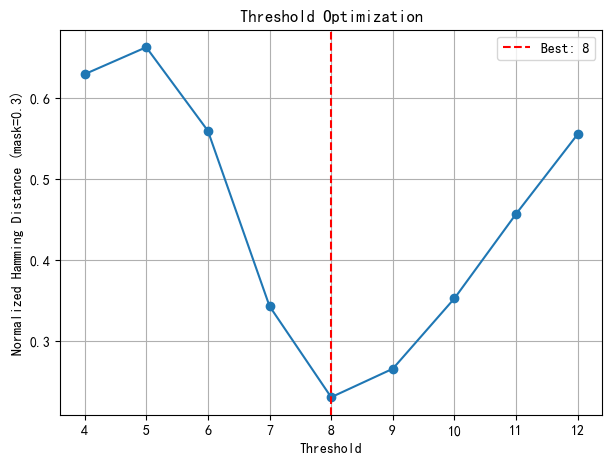


最优 threshold = 8，平均归一化海明距离 = 0.2302


In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from binary_btsp_network_torch import BinaryBTSPNetworkTorch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

n_input = 10000       # CA3 神经元数
n_memory = 15000      # CA1 神经元数
fq = 0.0025
fp = 0.005
fw = 0.6
batch_size = 256
n_repeats = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


mask_ratio = 0.3
memory_size = 8000   
threshold_values = np.arange(4, 13, 1)  


results = []

print(f"搜索不同 threshold 下的平均归一化海明距离 (mask_ratio={mask_ratio})...\n")


for th in tqdm(threshold_values, desc="Threshold scan"):
  
    net = BinaryBTSPNetworkTorch(
        n_input=n_input,
        n_memory=n_memory,
        fq=fq,
        fp=fp,
        fw=fw,
        device=device,
        threshold=th
    )

    # 生成输入模式
    patterns = net.make_sparse_patterns(memory_size)

    # 训练
    net.train_patterns(patterns, batch_size=batch_size)

    # 评估：仅一个掩码比例
    mean_rel_diss = net.compute_relative_dissimilarity_vectorized(
        patterns=patterns,
        mask_ratios=[mask_ratio],
        n_repeats=n_repeats,
        batch_size=batch_size,
    )[0]  # 提取单一结果

    results.append(mean_rel_diss)

results = np.array(results)


plt.figure(figsize=(7,5))
plt.plot(threshold_values, results, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Normalized Hamming Distance (mask=0.3)")
plt.title("Threshold Optimization")
plt.grid(True)

best_idx = np.argmin(results)
best_threshold = threshold_values[best_idx]
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best: {best_threshold}')
plt.legend()
plt.show()

print(f"\n最优 threshold = {best_threshold}，平均归一化海明距离 = {results[best_idx]:.4f}")


In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from binary_btsp_network_torch import BinaryBTSPNetworkTorch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


n_input = 10000
n_memory = 15000
fq = 0.0025
fp = 0.005
fw = 0.6
batch_size = 256
n_repeats = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

# 扫描参数
mask_ratio = 0.3
memory_sizes = np.arange(1000, 15000, 1000)     
threshold_values = np.arange(2, 15, 1)           

# 结果矩阵：行 = memory_size, 列 = threshold
results = np.zeros((len(memory_sizes), len(threshold_values)))

print(f"网格搜索不同 threshold × memory size 下的平均归一化海明距离 (mask_ratio={mask_ratio})...\n")


for i, n_pat in enumerate(tqdm(memory_sizes, desc="Memory sizes")):
    patterns = None
    for j, th in enumerate(threshold_values):
        net = BinaryBTSPNetworkTorch(
            n_input=n_input,
            n_memory=n_memory,
            fq=fq,
            fp=fp,
            fw=fw,
            device=device,
            threshold=th
        )

        if patterns is None:
            patterns = net.make_sparse_patterns(n_pat)

        net.train_patterns(patterns, batch_size=batch_size)

        mean_rel_diss = net.compute_relative_dissimilarity_vectorized(
            patterns=patterns,
            mask_ratios=[mask_ratio],
            n_repeats=n_repeats,
            batch_size=batch_size,
        )[0]

        results[i, j] = mean_rel_diss

  
    best_idx = np.argmin(results[i, :])
    best_th = threshold_values[best_idx]
    best_val = results[i, best_idx]



网格搜索不同 threshold × memory size 下的平均归一化海明距离 (mask_ratio=0.3)...



Memory sizes: 100%|██████████| 14/14 [32:31<00:00, 139.38s/it]


Memory size = 14000: 最佳 Threshold = 2, 平均归一化海明距离 = 0.2718


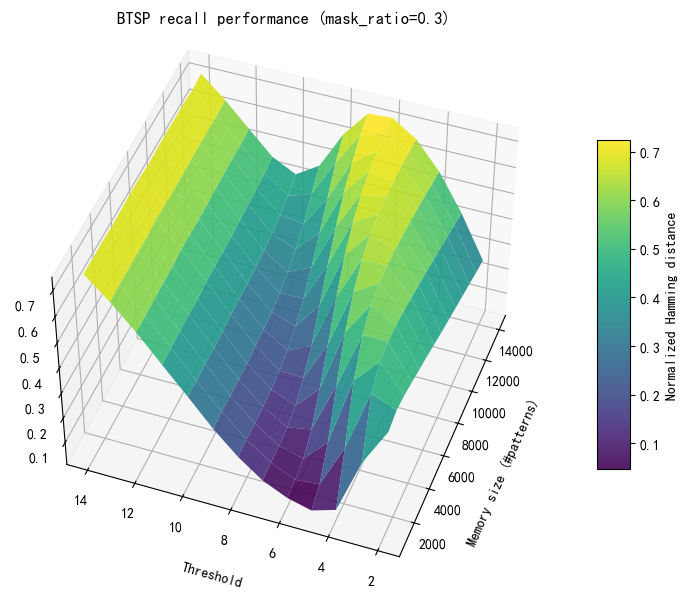

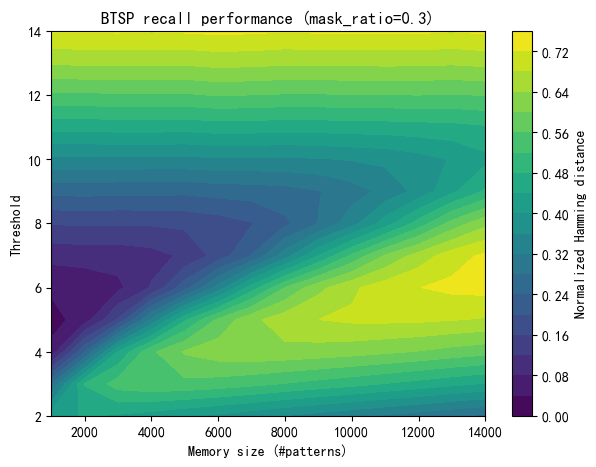


最优参数组合：Memory size = 1000, Threshold = 5, 平均归一化海明距离 = 0.0227


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
print(f"Memory size = {n_pat}: 最佳 Threshold = {best_th}, 平均归一化海明距离 = {best_val:.4f}")
%matplotlib inline



X, Y = np.meshgrid(memory_sizes, threshold_values, indexing='ij')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, results, cmap='viridis', edgecolor='none', alpha=0.9)


ax.set_xlabel("Memory size (#patterns)", labelpad=10)
ax.set_ylabel("Threshold", labelpad=10)
ax.set_zlabel("Normalized Hamming distance", labelpad=10)
ax.set_title(f"BTSP recall performance (mask_ratio={mask_ratio})")


fig.colorbar(surf, shrink=0.6, aspect=10, label="Normalized Hamming distance")


ax.view_init(elev=45, azim=200)  # 设置初始视角
ax.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(7,5))
cs = plt.contourf(memory_sizes, threshold_values, results.T, levels=20, cmap='viridis')
plt.xlabel("Memory size (#patterns)")
plt.ylabel("Threshold")
plt.title(f"BTSP recall performance (mask_ratio={mask_ratio})")
plt.colorbar(cs, label="Normalized Hamming distance")
plt.show()


best_idx = np.unravel_index(np.argmin(results), results.shape)
best_mem = memory_sizes[best_idx[0]]
best_th = threshold_values[best_idx[1]]
best_val = results[best_idx]

print(f"\n最优参数组合：Memory size = {best_mem}, Threshold = {best_th}, 平均归一化海明距离 = {best_val:.4f}")



Memory size=1000: best threshold=5, min normalized Hamming=0.0227
Memory size=2000: best threshold=6, min normalized Hamming=0.0525
Memory size=3000: best threshold=6, min normalized Hamming=0.0702
Memory size=4000: best threshold=7, min normalized Hamming=0.1056
Memory size=5000: best threshold=7, min normalized Hamming=0.1272
Memory size=6000: best threshold=7, min normalized Hamming=0.1763
Memory size=7000: best threshold=8, min normalized Hamming=0.1974
Memory size=8000: best threshold=8, min normalized Hamming=0.2314
Memory size=9000: best threshold=9, min normalized Hamming=0.2777
Memory size=10000: best threshold=9, min normalized Hamming=0.3015
Memory size=11000: best threshold=2, min normalized Hamming=0.3138
Memory size=12000: best threshold=2, min normalized Hamming=0.2999
Memory size=13000: best threshold=2, min normalized Hamming=0.2844
Memory size=14000: best threshold=2, min normalized Hamming=0.2718


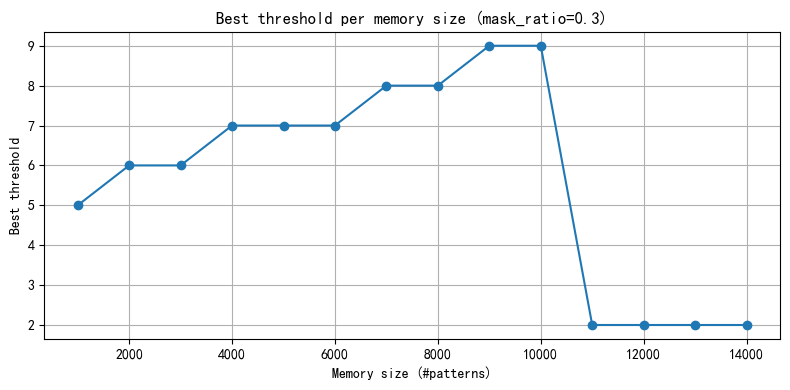

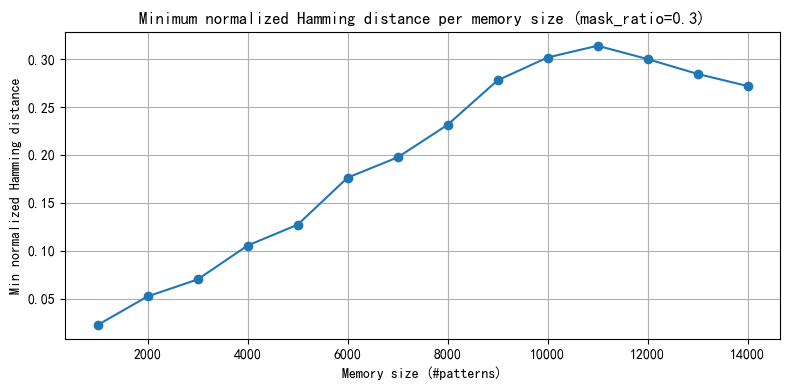

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

best_th_indices = np.argmin(results, axis=1)           # shape: (len(memory_sizes),)
best_thresholds = threshold_values[best_th_indices]    # 对应阈值
best_values = results[np.arange(results.shape[0]), best_th_indices]  # 对应最小值


for i, mem in enumerate(memory_sizes):
    print(f"Memory size={mem}: best threshold={best_thresholds[i]}, min normalized Hamming={best_values[i]:.4f}")


plt.figure(figsize=(8,4))
plt.plot(memory_sizes, best_thresholds, marker='o')
plt.xlabel("Memory size (#patterns)")
plt.ylabel("Best threshold")
plt.title(f"Best threshold per memory size (mask_ratio={mask_ratio})")
plt.grid(True)
plt.tight_layout()
plt.show()

# 可视化 2：对应的最小归一化海明距离随 memory size 变化
plt.figure(figsize=(8,4))
plt.plot(memory_sizes, best_values, marker='o')
plt.xlabel("Memory size (#patterns)")
plt.ylabel("Min normalized Hamming distance")
plt.title(f"Minimum normalized Hamming distance per memory size (mask_ratio={mask_ratio})")
plt.grid(True)
plt.tight_layout()
plt.show()